# Hardware-Aware ADAPT-VQE

We target a 12-qubit ring topology, since this is a subgraph of the heavy-hex qubit layout.

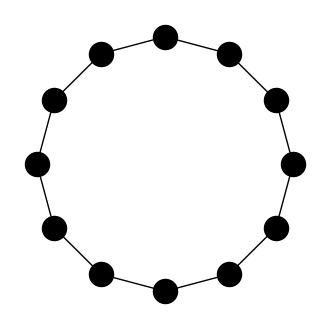

In [1]:
from networkx import Graph, draw_circular
from matplotlib import pyplot as plt
target_graph = Graph()
target_graph.add_edges_from([(i,i+1) for i in range(11)]+[(0,11)])
fig,ax=plt.subplots(figsize=(4,4))
draw_circular(target_graph, ax=ax, node_color='black')

In [2]:
with open('data/N2_hardware_aware_adapt_results.json', 'r') as infile:
    import json
    data = json.load(infile)
    cnots = data['standard_qubit_ADAPT']['num_nonlocal']
    scores = data['standard_qubit_ADAPT']['scores']
    energies = data['standard_qubit_ADAPT']['energies']
    ha_cnots = data['hardware_aware_ADAPT']['num_nonlocal']
    ha_scores = data['hardware_aware_ADAPT']['scores']
    ha_energies = data['hardware_aware_ADAPT']['energies']
    fci_energy = data['FCI_energy']

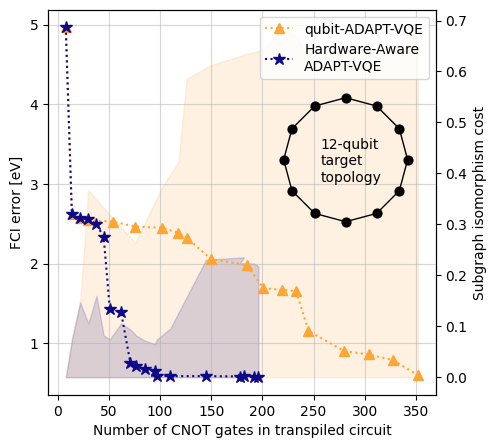

In [3]:
from matplotlib import pyplot as plt
from utils.plotting_styles import c0, c1, c2, c3, c4, c5
import numpy as np

ev_unit = 27.2114
fig, ax = plt.subplots(figsize=(5,5))
start = 1
end = 20
ax.plot(
    cnots[start:end], 
    (np.array(energies[start:end])-fci_energy)*ev_unit, 
    label='qubit-ADAPT-VQE', marker='^', color=c4, ms=7, ls=':'
)
ax.plot(
    ha_cnots[start:end], 
    (np.array(ha_energies[start:end])-fci_energy)*ev_unit, 
    label='Hardware-Aware\nADAPT-VQE', marker='*', color=c0, ms=9, ls=':'
)
ax.legend(ncol=1,loc='upper right')
ax.set_xlabel('Number of CNOT gates in transpiled circuit')
ax.set_ylabel('FCI error [eV]')
ax.grid(alpha=0.5)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax_cost = ax.twinx()
ax_cost.fill_between(cnots[start:end], 1-np.sqrt(scores[start:end]), 0, color=c4, alpha=0.15)
ax_cost.fill_between(ha_cnots[start:end], 1-np.sqrt(ha_scores[start:end]), 0, color=c0, alpha=0.15)
ax_cost.set_ylabel('Subgraph isomorphism cost')
ax.set_zorder(ax_cost.get_zorder() + 1)
ax.patch.set_visible(False)

left, bottom, width, height = [0.57, 0.43, 0.3, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])
draw_circular(target_graph, ax=ax2, node_size=40, node_color='black')
ax2.text(-0.4,-0.35,'12-qubit\ntarget\ntopology')
ax2.set_zorder(ax.get_zorder() + 1)
# ax.set_xlim(0,300)
fig.savefig('plots/N2_hardware_aware_adapt.png', dpi=300, bbox_inches='tight', transparent=True)

### Run below to regenerate data:

Build the molecule and project into 12-qubit contextual subspace:

In [148]:
from quac.chem_stable import MoleculeBuilder
from symmer import QubitTapering, ContextualSubspace
from symmer.process_handler import process; process.method = 'mp'

r=2
n_qubits = 12
mol = MoleculeBuilder(
    geometry=[('N',(0,0,0)),('N',(0,0,r))], symmetry=True, print_info=True,
    run_mp2=True,run_ccsd=True,run_cisd=True, run_fci=True,
)
QT = QubitTapering(mol.H_q)
H_taper = QT.taper_it(ref_state=mol.hf_array)
MP_taper = QT.taper_it(aux_operator=mol.MP_q - mol.MP_q.dagger)
CCSD_taper = QT.taper_it(aux_operator=mol.CC_q - mol.CC_q.dagger)
SYM_taper = {label:QT.taper_it(aux_operator=sym) for label, sym in mol.symmetries.items()}
ref_taper = QT.tapered_ref_state
CS = ContextualSubspace(
    operator=H_taper, 
    noncontextual_strategy='StabilizeFirst', 
    reference_state=ref_taper
)
CS.update_stabilizers(
    n_qubits, strategy='aux_preserving',
    aux_operator=CCSD_taper
)
H_cs = CS.project_onto_subspace()
CCSD_cs= CS.project_onto_subspace(CCSD_taper).cleanup(1e-2)
ref_cs = CS.project_state(ref_taper)
print(f'Number of terms in the truncated cluster pool: {CCSD_cs.n_terms}')

Molecule geometry:

N	0	0	0
N	0	0	2

CISD converged?  True
CCSD converged?  True
FCI converged?  True

HF energy:   -106.8715040456084
MP2 energy:  -107.77279685481103
CISD energy: -107.28567166988364
CCSD energy: -107.55698440609014
FCI energy:  -107.4551555977385

System of 14 particles in 20 spin-orbitals.
Number of terms in the truncated cluster pool: 164


Run the hardware-aware ADAPT-VQE routine using our custom VQE driver:

In [169]:
from utils.vqe_driver import ADAPT_VQE, topology_match_score, get_CNOT_connectivity_graph

max_cycles = 70
print('LB')
ha_adapt = ADAPT_VQE(observable=H_cs, excitation_pool=CCSD_cs, ref_state=ref_cs)
ha_adapt.expectation_eval= 'sparse_array'
ha_adapt.topology_aware = True
ha_adapt.topology = target_graph
ha_adapt.subgraph_match_depth = 12 # max depth search over 12-qubit ansatz
ha_adapt_result = ha_adapt.optimize(max_cycles=max_cycles, gtol=1e-6)

LB
---------------------------------------
ADAPT cycle 1

Largest pool derivative ∂P∂θ =  0.51177

Selected excitation generator(s):

	IIIIIYXXIIII

 ---------------------------------------
VQE simulation commencing...

Optimization step 0 :
	 Energy = -106.8715040456083
	    |∆| = 0.5117686924825762
Optimization step 1 :
	 Energy = -107.05982274537126
	    |∆| = 0.15878272317301878
Optimization step 2 :
	 Energy = -107.0689326880132
	    |∆| = 0.08104032539047523
Optimization step 3 :
	 Energy = -107.07206649618539
	    |∆| = 0.0006330485548318165
Optimization step 4 :
	 Energy = -107.0720666862816
	    |∆| = 2.501939363241945e-06

Energy at ADAPT cycle 1: -107.07207

---------------------------------------
ADAPT cycle 2

Largest pool derivative ∂P∂θ =  0.51177

Selected excitation generator(s):

	IIIIYIIIXXII

 ---------------------------------------
VQE simulation commencing...

Optimization step 0 :
	 Energy = -107.07206668628149
	    |∆| = 0.511768692488692
Optimization step 1 :
	

Run the standard qubit-ADAPT-VQE routine for comparison:

In [170]:
print('Standard')
adapt = ADAPT_VQE(observable=H_cs, excitation_pool=CCSD_cs, ref_state=ref_cs)
adapt.topology_aware = False
adapt.expectation_eval= 'sparse_array'
adapt_result = adapt.optimize(max_cycles=max_cycles, gtol=1e-6)

Standard


---------------------------------------
ADAPT cycle 1

Largest pool derivative ∂P∂θ =  0.51177

Selected excitation generator(s):

	IIIIIYXXIIII

 ---------------------------------------
VQE simulation commencing...

Optimization step 0 :
	 Energy = -106.8715040456083
	    |∆| = 0.5117686924825762
Optimization step 1 :
	 Energy = -107.05982274537126
	    |∆| = 0.15878272317301878
Optimization step 2 :
	 Energy = -107.0689326880132
	    |∆| = 0.08104032539047523
Optimization step 3 :
	 Energy = -107.07206649618539
	    |∆| = 0.0006330485548318165
Optimization step 4 :
	 Energy = -107.0720666862816
	    |∆| = 2.501939363241945e-06

Energy at ADAPT cycle 1: -107.07207

---------------------------------------
ADAPT cycle 2

Largest pool derivative ∂P∂θ =  0.51177

Selected excitation generator(s):

	IIIIXIIIXYII

 ---------------------------------------
VQE simulation commencing...

Optimization step 0 :
	 Energy = -107.07206668628149
	    |∆| = 0.511768692488692
Optimization step 1 :
	 En

Transpile the standard and hardware-aware results for the target topology so we may extract the required number of CNOT gates to implement each

In [313]:
from symmer.evolution import PauliwordOp_to_QuantumCircuit
from qiskit import transpile
from qiskit.transpiler import CouplingMap
from symmer import PauliwordOp, QuantumState
from warnings import filterwarnings
filterwarnings('ignore')
cnots = []
depths = []
scores = []
ha_cnots = []
ha_depths = []
ha_scores = []

coupling_map = CouplingMap(target_graph.edges)

for j in range(1, max_cycles+1):
    print(j)
    ansatz_generator = PauliwordOp.from_list(adapt_result['adapt_operator'][:j])
    circuit = PauliwordOp_to_QuantumCircuit(
        PwordOp=ansatz_generator, 
        ref_state=QuantumState.from_dictionary(adapt_result['ref_state']), 
        bind_params=True,include_barriers=False
    )
    qc_trans = transpile(circuit, optimization_level=1, coupling_map=coupling_map)
    qc_trans = transpile(qc_trans,basis_gates=['cx','rz','sx','x']) # decompose SWAPs
    cnots.append(qc_trans.num_nonlocal_gates())
    depths.append(qc_trans.depth())
    scores.append(topology_match_score(ansatz_generator, target_graph, max_depth=14))

    ha_ansatz_generator = PauliwordOp.from_list(ha_adapt_result['adapt_operator'][:j])
    ha_circuit = PauliwordOp_to_QuantumCircuit(
        PwordOp=ha_ansatz_generator, 
        ref_state=QuantumState.from_dictionary(ha_adapt_result['ref_state']), 
        bind_params=True,include_barriers=False
    )
    ha_qc_trans = transpile(ha_circuit, optimization_level=1, coupling_map=coupling_map)
    ha_qc_trans = transpile(ha_qc_trans,basis_gates=['cx','rz','sx','x']) # decompose SWAPs
    ha_cnots.append(ha_qc_trans.num_nonlocal_gates())
    ha_depths.append(ha_qc_trans.depth())
    ha_scores.append(topology_match_score(ha_ansatz_generator, target_graph, max_depth=14))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70


In [227]:
# data_out = {
#     'standard_qubit_ADAPT':{
#         'excitations':adapt_result['adapt_operator'],'num_nonlocal':cnots, 'depths':depths, 'energies':adapt_result['interim_data']['history'], 'scores':scores},
#     'hardware_aware_ADAPT':{
#         'excitations':ha_adapt_result['adapt_operator'],'num_nonlocal':ha_cnots, 'depths':ha_depths, 'energies':ha_adapt_result['interim_data']['history'], 'scores':ha_scores},
#     'FCI_energy':float(mol.fci_energy)
# }
# with open('data/N2_hardware_aware_adapt_results_2.json', 'w') as outfile:
#     import json
#     json.dump(data_out, outfile)